# ONNX Model Analysis Notebook

This notebook provides comprehensive analysis of ONNX model files, including:
- Model metadata and basic information
- Input/output tensor details
- Graph structure and node analysis
- Visual graph representation
- Memory and performance metrics


## Setup & Dependencies

Install required packages if not already installed.


In [18]:
# Install required packages (uncomment if needed)
# !pip install onnx onnxruntime matplotlib networkx pandas numpy

In [19]:
import onnx
import onnxruntime as ort
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from pathlib import Path
from collections import Counter, defaultdict
import json
from typing import Dict, List, Tuple, Optional

## Model Loading

Function to load ONNX models with error handling.


In [20]:
def load_onnx_model(model_path: str) -> Optional[onnx.ModelProto]:
    """
    Load an ONNX model from a file path.

    Args:
        model_path: Path to the ONNX model file

    Returns:
        ONNX ModelProto object or None if loading fails
    """
    try:
        if not os.path.exists(model_path):
            print(f"Error: File not found: {model_path}")
            return None

        model = onnx.load(model_path)
        print(f"✓ Successfully loaded model: {model_path}")
        print(f"  File size: {os.path.getsize(model_path) / (1024*1024):.2f} MB")
        return model
    except Exception as e:
        print(f"Error loading model {model_path}: {str(e)}")
        return None

## Basic Model Information

Extract and display model metadata, version, and basic information.


In [21]:
def get_model_info(model: onnx.ModelProto, model_path: str) -> Dict:
    """
    Extract basic information about the ONNX model.

    Returns:
        Dictionary containing model information
    """
    info = {
        'model_path': model_path,
        'file_size_mb': os.path.getsize(model_path) / (1024*1024),
        'ir_version': model.ir_version,
        'producer_name': model.producer_name,
        'producer_version': model.producer_version,
        'domain': model.domain,
        'model_version': model.model_version,
        'doc_string': model.doc_string if model.doc_string else "N/A"
    }

    # Count parameters (approximate)
    param_count = 0
    for initializer in model.graph.initializer:
        shape = list(initializer.dims)
        if shape:
            param_count += np.prod(shape)

    info['estimated_parameters'] = param_count
    info['estimated_parameters_millions'] = param_count / 1e6

    return info


def display_model_info(info: Dict):
    """Display model information in a formatted way."""
    print("=" * 60)
    print("MODEL INFORMATION")
    print("=" * 60)
    print(f"File Path:        {info['model_path']}")
    print(f"File Size:        {info['file_size_mb']:.2f} MB")
    print(f"IR Version:       {info['ir_version']}")
    print(f"Producer:         {info['producer_name']} v{info['producer_version']}")
    print(f"Domain:           {info['domain']}")
    print(f"Model Version:    {info['model_version']}")
    print(f"Estimated Params: {info['estimated_parameters_millions']:.2f}M ({info['estimated_parameters']:,})")
    print(f"Documentation:    {info['doc_string']}")
    print("=" * 60)

## Input/Output Analysis

Analyze input and output tensors with detailed information.


In [22]:
def get_tensor_info(tensor: onnx.ValueInfoProto) -> Dict:
    """Extract information from a tensor ValueInfoProto."""
    shape = [dim.dim_value if dim.dim_value > 0 else dim.dim_param
             for dim in tensor.type.tensor_type.shape.dim]
    shape_str = str(shape).replace("'", "")

    return {
        'name': tensor.name,
        'shape': shape_str,
        'data_type': onnx.TensorProto.DataType.Name(tensor.type.tensor_type.elem_type),
        'description': tensor.doc_string if tensor.doc_string else "N/A"
    }


def analyze_inputs_outputs(model: onnx.ModelProto) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Analyze model inputs and outputs.

    Returns:
        Tuple of (inputs_df, outputs_df) DataFrames
    """
    inputs = [get_tensor_info(inp) for inp in model.graph.input]
    outputs = [get_tensor_info(out) for out in model.graph.output]

    inputs_df = pd.DataFrame(inputs)
    outputs_df = pd.DataFrame(outputs)

    return inputs_df, outputs_df


def display_inputs_outputs(inputs_df: pd.DataFrame, outputs_df: pd.DataFrame):
    """Display input and output information."""
    print("\n" + "=" * 60)
    print("INPUT TENSORS")
    print("=" * 60)
    if len(inputs_df) > 0:
        print(inputs_df.to_string(index=False))
    else:
        print("No inputs found")

    print("\n" + "=" * 60)
    print("OUTPUT TENSORS")
    print("=" * 60)
    if len(outputs_df) > 0:
        print(outputs_df.to_string(index=False))
    else:
        print("No outputs found")
    print("=" * 60)

## Graph Structure Analysis

Analyze the computation graph structure, nodes, and operators.


In [23]:
def analyze_graph_structure(model: onnx.ModelProto) -> Dict:
    """
    Analyze the graph structure of the ONNX model.

    Returns:
        Dictionary with graph analysis results
    """
    graph = model.graph
    nodes = graph.node

    # Count nodes and operators
    operator_counts = Counter(node.op_type for node in nodes)
    total_nodes = len(nodes)

    # Get all unique operators
    unique_operators = sorted(operator_counts.keys())

    # Build graph for depth analysis
    G = nx.DiGraph()

    # Add all nodes
    for node in nodes:
        G.add_node(node.name, op_type=node.op_type)

    # Add edges based on input/output connections
    value_to_node = {}
    for node in nodes:
        for output in node.output:
            value_to_node[output] = node.name

    for node in nodes:
        for inp in node.input:
            if inp in value_to_node:
                G.add_edge(value_to_node[inp], node.name)

    # Calculate graph metrics
    try:
        if len(G.nodes) > 0:
            # Find longest path (approximate depth)
            if nx.is_directed_acyclic_graph(G):
                longest_path = nx.dag_longest_path(G)
                graph_depth = len(longest_path) - 1
            else:
                graph_depth = "N/A (cyclic graph)"

            # Count initializers
            initializer_count = len(graph.initializer)

            # Count intermediate values
            all_values = set()
            for node in nodes:
                all_values.update(node.input)
                all_values.update(node.output)
            intermediate_values = all_values - set(inp.name for inp in graph.input) - set(out.name for out in graph.output)

            analysis = {
                'total_nodes': total_nodes,
                'total_edges': G.number_of_edges(),
                'graph_depth': graph_depth,
                'unique_operators': len(unique_operators),
                'operator_counts': dict(operator_counts),
                'operator_list': unique_operators,
                'initializer_count': initializer_count,
                'intermediate_values': len(intermediate_values),
                'graph': G
            }
        else:
            analysis = {
                'total_nodes': total_nodes,
                'total_edges': 0,
                'graph_depth': 0,
                'unique_operators': len(unique_operators),
                'operator_counts': dict(operator_counts),
                'operator_list': unique_operators,
                'initializer_count': len(graph.initializer),
                'intermediate_values': 0,
                'graph': None
            }
    except Exception as e:
        print(f"Warning: Could not compute all graph metrics: {e}")
        analysis = {
            'total_nodes': total_nodes,
            'unique_operators': len(unique_operators),
            'operator_counts': dict(operator_counts),
            'operator_list': unique_operators,
            'initializer_count': len(graph.initializer),
            'graph': None
        }

    return analysis


def display_graph_structure(analysis: Dict):
    """Display graph structure information."""
    print("\n" + "=" * 60)
    print("GRAPH STRUCTURE")
    print("=" * 60)
    print(f"Total Nodes:           {analysis['total_nodes']}")
    if 'total_edges' in analysis:
        print(f"Total Edges:           {analysis['total_edges']}")
    if 'graph_depth' in analysis:
        print(f"Graph Depth:           {analysis['graph_depth']}")
    print(f"Unique Operators:      {analysis['unique_operators']}")
    print(f"Initializers:          {analysis['initializer_count']}")
    if 'intermediate_values' in analysis:
        print(f"Intermediate Values:   {analysis['intermediate_values']}")

    print("\n" + "-" * 60)
    print("OPERATOR DISTRIBUTION")
    print("-" * 60)
    operator_df = pd.DataFrame([
        {'Operator': op, 'Count': count}
        for op, count in sorted(analysis['operator_counts'].items(), key=lambda x: x[1], reverse=True)
    ])
    print(operator_df.to_string(index=False))
    print("=" * 60)

In [24]:
def get_node_details(model: onnx.ModelProto) -> pd.DataFrame:
    """
    Extract detailed information about each node.

    Returns:
        DataFrame with node details
    """
    nodes_data = []

    for i, node in enumerate(model.graph.node):
        # Get attributes
        attrs = {}
        for attr in node.attribute:
            if attr.type == onnx.AttributeProto.INT:
                attrs[attr.name] = attr.i
            elif attr.type == onnx.AttributeProto.FLOAT:
                attrs[attr.name] = attr.f
            elif attr.type == onnx.AttributeProto.STRING:
                attrs[attr.name] = attr.s.decode('utf-8')
            elif attr.type == onnx.AttributeProto.INTS:
                attrs[attr.name] = list(attr.ints)
            elif attr.type == onnx.AttributeProto.FLOATS:
                attrs[attr.name] = list(attr.floats)
            else:
                attrs[attr.name] = f"<{onnx.AttributeProto.AttributeType.Name(attr.type)}>"

        nodes_data.append({
            'index': i,
            'name': node.name if node.name else f"node_{i}",
            'op_type': node.op_type,
            'inputs': ', '.join(node.input),
            'outputs': ', '.join(node.output),
            'attributes': str(attrs) if attrs else "None"
        })

    return pd.DataFrame(nodes_data)


def display_node_details(nodes_df: pd.DataFrame, max_rows: int = 20):
    """Display node details (showing first max_rows by default)."""
    print("\n" + "=" * 60)
    print(f"NODE DETAILS (showing first {min(max_rows, len(nodes_df))} of {len(nodes_df)} nodes)")
    print("=" * 60)
    print(nodes_df.head(max_rows).to_string(index=False))
    if len(nodes_df) > max_rows:
        print(f"\n... and {len(nodes_df) - max_rows} more nodes")
    print("=" * 60)

## Graph Visualization

Create visual representation of the computation graph.


In [25]:
def visualize_graph(analysis: Dict, model: onnx.ModelProto, figsize: Tuple[int, int] = (20, 12),
                    max_nodes: int = 100, layout: str = 'spring'):
    """
    Visualize the ONNX computation graph.

    Args:
        analysis: Graph analysis dictionary
        model: ONNX model
        figsize: Figure size
        max_nodes: Maximum number of nodes to display (for large graphs)
        layout: Layout algorithm ('spring', 'hierarchical', 'circular')
    """
    if analysis.get('graph') is None or len(analysis['graph'].nodes) == 0:
        print("Cannot visualize: Graph is empty or could not be constructed")
        return

    G = analysis['graph']

    # Limit nodes for visualization if graph is too large
    if len(G.nodes) > max_nodes:
        print(f"Graph has {len(G.nodes)} nodes. Showing first {max_nodes} nodes for visualization.")
        nodes_to_show = list(G.nodes)[:max_nodes]
        G = G.subgraph(nodes_to_show).copy()

    # Create color map based on operator type
    op_types = [G.nodes[node].get('op_type', 'Unknown') for node in G.nodes]
    unique_ops = list(set(op_types))
    color_map = plt.cm.tab20(np.linspace(0, 1, len(unique_ops)))
    op_to_color = {op: color_map[i] for i, op in enumerate(unique_ops)}
    node_colors = [op_to_color[G.nodes[node].get('op_type', 'Unknown')] for node in G.nodes]

    # Create figure
    plt.figure(figsize=figsize)

    # Choose layout
    if layout == 'hierarchical':
        try:
            pos = nx.nx_agraph.graphviz_layout(G, prog='dot')
        except:
            pos = nx.spring_layout(G, k=2, iterations=50)
    elif layout == 'circular':
        pos = nx.circular_layout(G)
    else:  # spring
        pos = nx.spring_layout(G, k=1.5, iterations=50)

    # Draw graph
    nx.draw(G, pos,
            with_labels=True,
            node_color=node_colors,
            node_size=1000,
            font_size=8,
            font_weight='bold',
            arrows=True,
            arrowsize=20,
            edge_color='gray',
            alpha=0.7,
            width=1.5)

    # Create legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=op_to_color[op], label=op) for op in unique_ops]
    plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1))

    plt.title(f"ONNX Computation Graph ({len(G.nodes)} nodes, {len(G.edges)} edges)",
              fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Print operator color mapping
    print("\nOperator Color Mapping:")
    for op, color in sorted(op_to_color.items()):
        rgb = tuple(int(c * 255) for c in color[:3])
        print(f"  {op}: RGB{rgb}")

## Memory & Performance Analysis

Analyze memory usage and performance characteristics.


In [26]:
def analyze_memory_performance(model: onnx.ModelProto, model_path: str,
                               analysis: Dict) -> Dict:
    """
    Analyze memory usage and performance characteristics.

    Returns:
        Dictionary with memory and performance metrics
    """
    metrics = {}

    # File size
    file_size = os.path.getsize(model_path)
    metrics['file_size_bytes'] = file_size
    metrics['file_size_mb'] = file_size / (1024 * 1024)

    # Calculate model weights size
    weights_size = 0
    for initializer in model.graph.initializer:
        # Get data type size
        dtype = initializer.data_type
        if dtype == onnx.TensorProto.FLOAT:
            elem_size = 4
        elif dtype == onnx.TensorProto.DOUBLE:
            elem_size = 8
        elif dtype == onnx.TensorProto.INT32 or dtype == onnx.TensorProto.INT64:
            elem_size = 4 if dtype == onnx.TensorProto.INT32 else 8
        else:
            elem_size = 4  # default assumption

        shape = list(initializer.dims)
        if shape:
            num_elements = np.prod(shape)
            weights_size += num_elements * elem_size

    metrics['weights_size_bytes'] = weights_size
    metrics['weights_size_mb'] = weights_size / (1024 * 1024)

    # ONNX Runtime session info
    try:
        session = ort.InferenceSession(model_path)
        providers = session.get_providers()
        input_meta = session.get_inputs()
        output_meta = session.get_outputs()

        metrics['onnxruntime_providers'] = providers
        metrics['onnxruntime_inputs'] = len(input_meta)
        metrics['onnxruntime_outputs'] = len(output_meta)

        # Get input/output metadata
        input_details = []
        for inp in input_meta:
            input_details.append({
                'name': inp.name,
                'shape': inp.shape,
                'type': inp.type
            })
        metrics['input_details'] = input_details

        output_details = []
        for out in output_meta:
            output_details.append({
                'name': out.name,
                'shape': out.shape,
                'type': out.type
            })
        metrics['output_details'] = output_details

    except Exception as e:
        metrics['onnxruntime_error'] = str(e)
        print(f"Warning: Could not create ONNX Runtime session: {e}")

    # Graph complexity metrics
    if 'total_nodes' in analysis:
        metrics['total_nodes'] = analysis['total_nodes']
    if 'total_edges' in analysis:
        metrics['total_edges'] = analysis['total_edges']
    if 'graph_depth' in analysis:
        metrics['graph_depth'] = analysis['graph_depth']

    # Complexity score (simple heuristic)
    complexity = 0
    if 'total_nodes' in metrics:
        complexity += metrics['total_nodes'] * 10
    if 'total_edges' in metrics:
        complexity += metrics['total_edges'] * 5
    if 'weights_size_mb' in metrics:
        complexity += metrics['weights_size_mb'] * 100

    metrics['complexity_score'] = complexity

    return metrics


def display_memory_performance(metrics: Dict):
    """Display memory and performance information."""
    print("\n" + "=" * 60)
    print("MEMORY & PERFORMANCE ANALYSIS")
    print("=" * 60)
    print(f"File Size:           {metrics['file_size_mb']:.2f} MB ({metrics['file_size_bytes']:,} bytes)")
    print(f"Weights Size:        {metrics['weights_size_mb']:.2f} MB ({metrics['weights_size_bytes']:,} bytes)")

    if 'total_nodes' in metrics:
        print(f"Total Nodes:         {metrics['total_nodes']}")
    if 'total_edges' in metrics:
        print(f"Total Edges:         {metrics['total_edges']}")
    if 'graph_depth' in metrics:
        print(f"Graph Depth:         {metrics['graph_depth']}")

    print(f"Complexity Score:    {metrics['complexity_score']:.0f}")

    if 'onnxruntime_providers' in metrics:
        print("\n" + "-" * 60)
        print("ONNX RUNTIME INFO")
        print("-" * 60)
        print(f"Available Providers: {', '.join(metrics['onnxruntime_providers'])}")
        print(f"Inputs:              {metrics['onnxruntime_inputs']}")
        print(f"Outputs:             {metrics['onnxruntime_outputs']}")

        if 'input_details' in metrics:
            print("\nInput Details:")
            for inp in metrics['input_details']:
                print(f"  - {inp['name']}: shape={inp['shape']}, type={inp['type']}")

        if 'output_details' in metrics:
            print("\nOutput Details:")
            for out in metrics['output_details']:
                print(f"  - {out['name']}: shape={out['shape']}, type={out['type']}")

    print("=" * 60)

## Summary Report

Generate a comprehensive summary of all analysis results.


In [27]:
def generate_summary(model_info: Dict, inputs_df: pd.DataFrame, outputs_df: pd.DataFrame,
                     graph_analysis: Dict, memory_metrics: Dict) -> Dict:
    """
    Generate a comprehensive summary of the analysis.

    Returns:
        Dictionary with summary information
    """
    summary = {
        'model_info': model_info,
        'inputs': inputs_df.to_dict('records') if len(inputs_df) > 0 else [],
        'outputs': outputs_df.to_dict('records') if len(outputs_df) > 0 else [],
        'graph_analysis': {
            'total_nodes': graph_analysis.get('total_nodes', 0),
            'total_edges': graph_analysis.get('total_edges', 0),
            'graph_depth': str(graph_analysis.get('graph_depth', 'N/A')),
            'unique_operators': graph_analysis.get('unique_operators', 0),
            'operator_counts': graph_analysis.get('operator_counts', {})
        },
        'memory_metrics': {
            'file_size_mb': memory_metrics.get('file_size_mb', 0),
            'weights_size_mb': memory_metrics.get('weights_size_mb', 0),
            'complexity_score': memory_metrics.get('complexity_score', 0)
        }
    }

    return summary


def display_summary(summary: Dict):
    """Display a formatted summary report."""
    print("\n" + "=" * 60)
    print("COMPREHENSIVE SUMMARY REPORT")
    print("=" * 60)

    print("\n📋 MODEL OVERVIEW")
    print("-" * 60)
    info = summary['model_info']
    print(f"File:              {info['model_path']}")
    print(f"Size:              {info['file_size_mb']:.2f} MB")
    print(f"Parameters:        {info['estimated_parameters_millions']:.2f}M")
    print(f"Producer:          {info['producer_name']} v{info['producer_version']}")
    print(f"IR Version:        {info['ir_version']}")

    print("\n📥 INPUTS")
    print("-" * 60)
    if summary['inputs']:
        for inp in summary['inputs']:
            print(f"  • {inp['name']}: {inp['shape']} ({inp['data_type']})")
    else:
        print("  No inputs")

    print("\n📤 OUTPUTS")
    print("-" * 60)
    if summary['outputs']:
        for out in summary['outputs']:
            print(f"  • {out['name']}: {out['shape']} ({out['data_type']})")
    else:
        print("  No outputs")

    print("\n🔗 GRAPH STRUCTURE")
    print("-" * 60)
    ga = summary['graph_analysis']
    print(f"Nodes:             {ga['total_nodes']}")
    print(f"Edges:             {ga['total_edges']}")
    print(f"Depth:             {ga['graph_depth']}")
    print(f"Unique Operators:  {ga['unique_operators']}")

    print("\n💾 MEMORY & PERFORMANCE")
    print("-" * 60)
    mm = summary['memory_metrics']
    print(f"File Size:         {mm['file_size_mb']:.2f} MB")
    print(f"Weights Size:      {mm['weights_size_mb']:.2f} MB")
    print(f"Complexity Score: {mm['complexity_score']:.0f}")

    print("\n" + "=" * 60)


def save_summary(summary: Dict, output_path: str):
    """Save summary to a JSON file."""
    # Convert numpy types to native Python types for JSON serialization
    def convert_to_serializable(obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, dict):
            return {key: convert_to_serializable(value) for key, value in obj.items()}
        elif isinstance(obj, list):
            return [convert_to_serializable(item) for item in obj]
        return obj

    serializable_summary = convert_to_serializable(summary)

    with open(output_path, 'w') as f:
        json.dump(serializable_summary, f, indent=2)

    print(f"✓ Summary saved to: {output_path}")

## Main Analysis Function

Convenience function to run complete analysis on an ONNX model.


In [28]:
def analyze_onnx_model(model_path: str, visualize: bool = True,
                       max_vis_nodes: int = 100, save_summary_file: Optional[str] = None):
    """
    Run complete analysis on an ONNX model.

    Args:
        model_path: Path to the ONNX model file
        visualize: Whether to create graph visualization
        max_vis_nodes: Maximum nodes to show in visualization
        save_summary_file: Optional path to save summary JSON file
    """
    # Load model
    model = load_onnx_model(model_path)
    if model is None:
        return None

    # Run all analyses
    print("\n" + "🔍 " * 30)
    print("RUNNING COMPREHENSIVE ANALYSIS")
    print("🔍 " * 30 + "\n")

    # Model info
    model_info = get_model_info(model, model_path)
    display_model_info(model_info)

    # Inputs/Outputs
    inputs_df, outputs_df = analyze_inputs_outputs(model)
    display_inputs_outputs(inputs_df, outputs_df)

    # Graph structure
    graph_analysis = analyze_graph_structure(model)
    display_graph_structure(graph_analysis)

    # Node details
    nodes_df = get_node_details(model)
    display_node_details(nodes_df)

    # Memory & Performance
    memory_metrics = analyze_memory_performance(model, model_path, graph_analysis)
    display_memory_performance(memory_metrics)

    # Visualization
    if visualize:
        print("\n" + "=" * 60)
        print("GRAPH VISUALIZATION")
        print("=" * 60)
        visualize_graph(graph_analysis, model, max_nodes=max_vis_nodes)

    # Summary
    summary = generate_summary(model_info, inputs_df, outputs_df, graph_analysis, memory_metrics)
    display_summary(summary)

    # Save summary if requested
    if save_summary_file:
        save_summary(summary, save_summary_file)

    return {
        'model': model,
        'model_info': model_info,
        'inputs_df': inputs_df,
        'outputs_df': outputs_df,
        'graph_analysis': graph_analysis,
        'nodes_df': nodes_df,
        'memory_metrics': memory_metrics,
        'summary': summary
    }

## Usage Example

Analyze an ONNX model file. You can use either the convenience function or call individual analysis functions.


✓ Successfully loaded model: models/GameModel.onnx
  File size: 0.02 MB

🔍 🔍 🔍 🔍 🔍 🔍 🔍 🔍 🔍 🔍 🔍 🔍 🔍 🔍 🔍 🔍 🔍 🔍 🔍 🔍 🔍 🔍 🔍 🔍 🔍 🔍 🔍 🔍 🔍 🔍 
RUNNING COMPREHENSIVE ANALYSIS
🔍 🔍 🔍 🔍 🔍 🔍 🔍 🔍 🔍 🔍 🔍 🔍 🔍 🔍 🔍 🔍 🔍 🔍 🔍 🔍 🔍 🔍 🔍 🔍 🔍 🔍 🔍 🔍 🔍 🔍 

MODEL INFORMATION
File Path:        models/GameModel.onnx
File Size:        0.02 MB
IR Version:       8
Producer:         pytorch v2.8.0
Domain:           
Model Version:    0
Estimated Params: 0.00M (4,610)
Documentation:    N/A

INPUT TENSORS
     name           shape data_type description
      obs [batch_size, 4]     FLOAT         N/A
state_ins    [batch_size]     FLOAT         N/A

OUTPUT TENSORS
      name           shape data_type description
    output [batch_size, 2]     FLOAT         N/A
state_outs    [batch_size]     FLOAT         N/A

GRAPH STRUCTURE
Total Nodes:           8
Total Edges:           6
Graph Depth:           6
Unique Operators:      5
Initializers:          6
Intermediate Values:   12

----------------------------------------------------

/var/folders/__/t_gwrrdd78zb5fgsrx4k2wkm0000gn/T/ipykernel_66623/1510806461.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


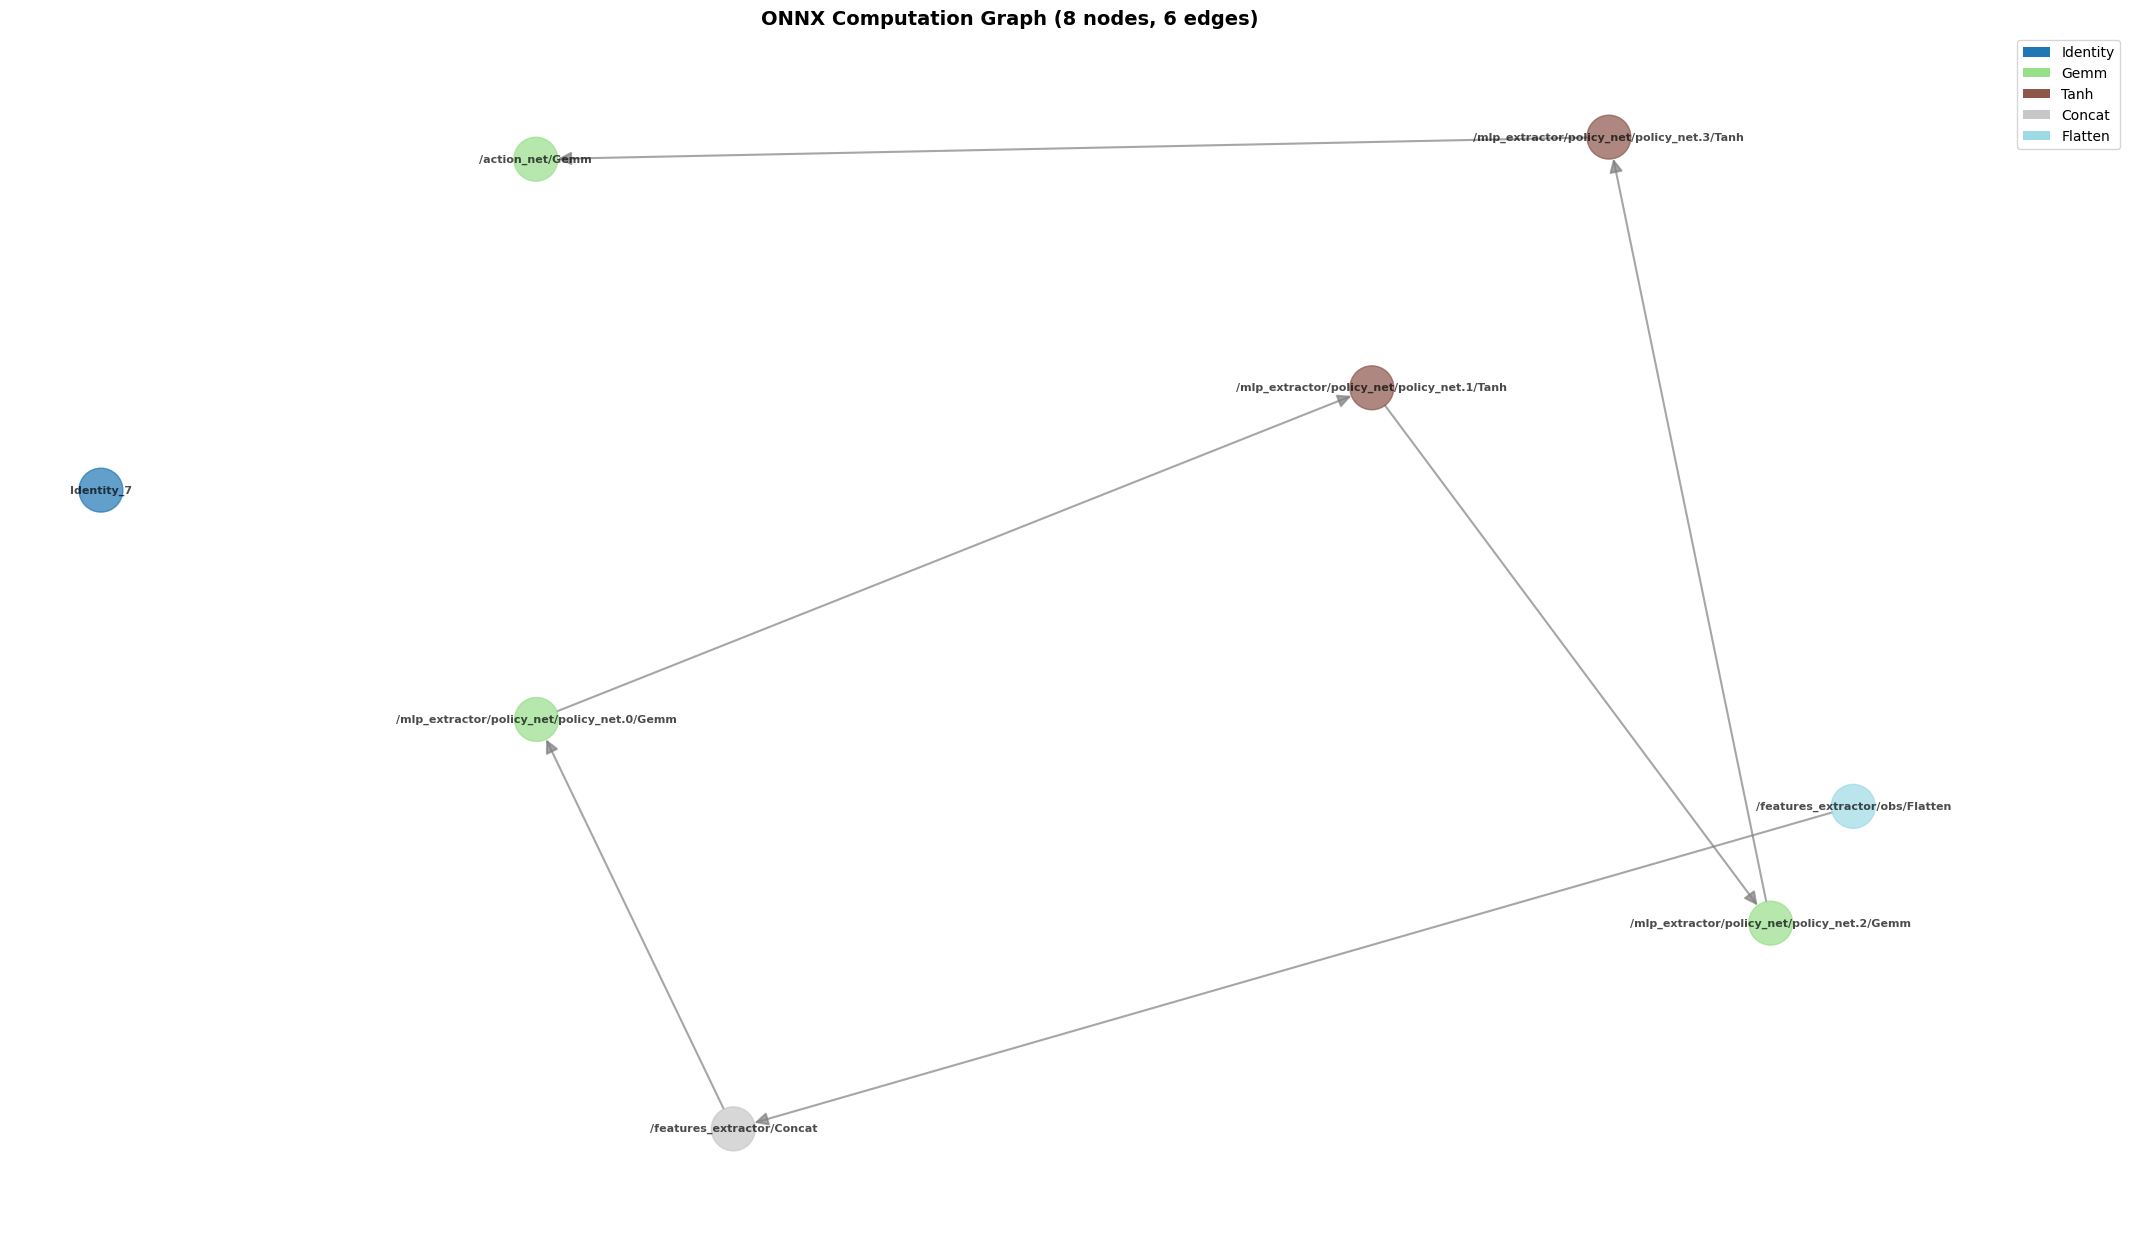


Operator Color Mapping:
  Concat: RGB(199, 199, 199)
  Flatten: RGB(158, 218, 229)
  Gemm: RGB(152, 223, 138)
  Identity: RGB(31, 119, 180)
  Tanh: RGB(140, 86, 75)

COMPREHENSIVE SUMMARY REPORT

📋 MODEL OVERVIEW
------------------------------------------------------------
File:              models/GameModel.onnx
Size:              0.02 MB
Parameters:        0.00M
Producer:          pytorch v2.8.0
IR Version:        8

📥 INPUTS
------------------------------------------------------------
  • obs: [batch_size, 4] (FLOAT)
  • state_ins: [batch_size] (FLOAT)

📤 OUTPUTS
------------------------------------------------------------
  • output: [batch_size, 2] (FLOAT)
  • state_outs: [batch_size] (FLOAT)

🔗 GRAPH STRUCTURE
------------------------------------------------------------
Nodes:             8
Edges:             6
Depth:             6
Unique Operators:  5

💾 MEMORY & PERFORMANCE
------------------------------------------------------------
File Size:         0.02 MB
Weights Size:   

In [29]:
# Example: Analyze a model using the convenience function
# Uncomment and modify the path as needed

results = analyze_onnx_model(
    model_path="models/GameModel.onnx",
    visualize=True,
    max_vis_nodes=100,
    save_summary_file="model_analysis_summary.json"  # Optional
)